# Mercury Challenge Time Series Baserate Models

This notebook explains the development of the Mercury Challenge Baserate models for the Case Count events.  We present the underlying time series data, and examine autocorrelation and partial autocorrelation functions.  Using the first 2/3 of the series history we fit a family of ARIMA(p,d,q) models and evaluate on the final 1/3 of the series history, using an error function derived from the Mercury Challenge Quality Score function.  $Error = mean(1 - QS)$.  Finally, we make predictions for the most recent history (3 months for monthly events, 1 month for weekly and daily events) by fitting a model of the optimal order to the series that precedes the final period and making predictions.

In [1]:
%matplotlib inline

In [51]:
import os
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import datetime
from dateutil.parser import parse
import sys
sys.path.append(("../.."))
from Baserate.main.timeseries import (
    evaluate_arima_model, 
    evaluate_models, 
    mean_qs_error, 
    TsDefaults,
    one_step_ahead_forecast,
    hist_avg_predict,
    future_dates
)
from ExpressScore.main.express_score import CaseCountScorer
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("fivethirtyeight");

In [3]:
MC_HOME = os.path.abspath("../../..")
DATA_PATH = os.path.join(MC_HOME, "data")
GSR_PATH = os.path.join(DATA_PATH, "gsr")
CU_COUNT_GSR_PATH = os.path.join(GSR_PATH, "cu_count_gsr")
DISEASE_GSR_PATH = os.path.join(GSR_PATH, "disease_gsr")
RESOURCE_PATH = os.path.join(MC_HOME, "src", "Baserate", "resources")

P_MAX = TsDefaults.P_MAX # Up to lag 4
D_MAX = TsDefaults.D_MAX # Up to the first difference
Q_MAX = TsDefaults.Q_MAX # Up to lag 4

model_eval_dict = dict()

## Disease Count Series

In [37]:
os.listdir(DISEASE_GSR_PATH)

['Saudi_Arabia_Weekly_MERS_Counts.json']

The Baserate model for Disease Case Count is different than the models used for Civil Unrest, owing to the seasonal nature of MERS.  This model computes a historical average for the week in question and scales it by the ratio of recent weeks to their historical averages.

Data from 2015-05-03 00:00:00 to 2018-06-24 00:00:00


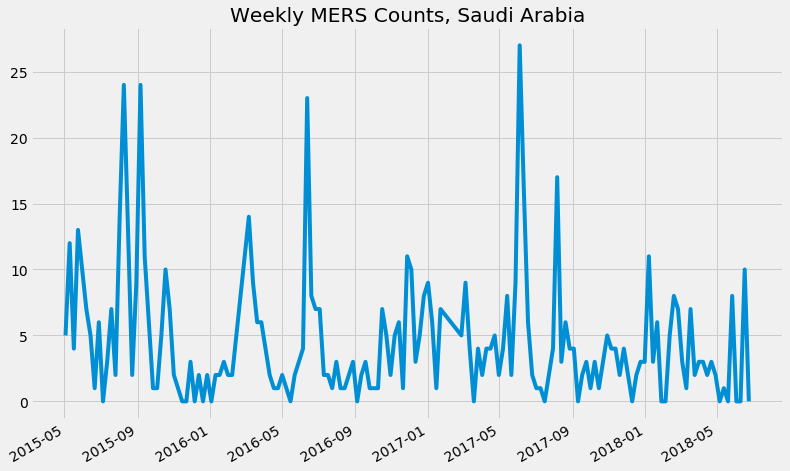

In [78]:
freq = "Weekly"
filename_ = "Saudi_Arabia_Weekly_MERS_Counts.json"
filepath_ = os.path.join(DISEASE_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
#count_dict = {parse(e["Event_Date"]).date(): e["Case_Count"] for e in gsr_}
count_values = [e["Case_Count"] for e in gsr_]
index_ = pd.DatetimeIndex([parse(e["Event_Date"]).date() for e in gsr_])
count_ser = pd.Series(count_values, index=index_)
count_ser = count_ser.sort_index()
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("Weekly MERS Counts, Saudi Arabia");

Testing for Stationary Behavior
ADF Statistic: -8.049
p = 1.7669060414225984e-12
Critical Values:
1%: -3.472
5%: -2.880
10%: -2.577
ADF Test rejects null hypothesis of non-stationarity


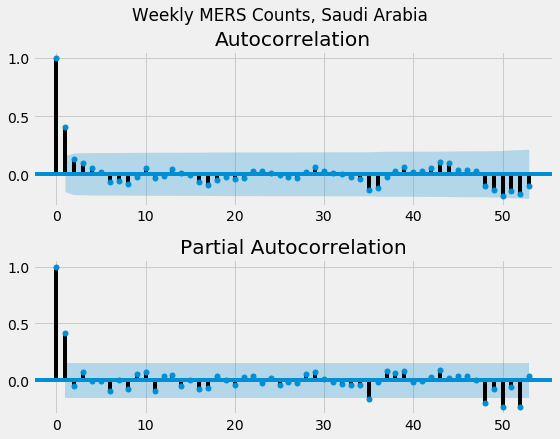

In [79]:
print("Testing for Stationary Behavior")
result = adfuller(count_ser)
print("ADF Statistic: {:.3f}".format(result[0]))
print("p = {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("{0}: {1:.3f}".format(key, value))
if result[0] <= result[4]["5%"]:
    print("ADF Test rejects null hypothesis of non-stationarity")
else:
    print("ADF Test cannot reject null hypothesis of non-stationarity")

fig, axes = plt.subplots(2,1, figsize=(8, 6))
plot_acf(count_ser, ax=axes[0], unbiased=False, lags=53)
plot_pacf(count_ser, ax=axes[1], lags=53)
fig.suptitle("Weekly MERS Counts, Saudi Arabia", y=1.02)
fig.tight_layout()

In [80]:
test_start_date = "2018-06-01"
train = count_ser[:test_start_date]
test = count_ser[test_start_date:]
predictions = hist_avg_predict(train, n_ahead=len(test), freq=52)
predictions

TypeError: 'NoneType' object is not subscriptable

In [81]:
count_ser.index

DatetimeIndex(['2015-05-03', '2015-05-10', '2015-05-17', '2015-05-24',
               '2015-05-31', '2015-06-07', '2015-06-14', '2015-06-21',
               '2015-06-28', '2015-07-05',
               ...
               '2018-04-22', '2018-04-29', '2018-05-06', '2018-05-13',
               '2018-05-20', '2018-05-27', '2018-06-03', '2018-06-10',
               '2018-06-17', '2018-06-24'],
              dtype='datetime64[ns]', length=160, freq=None)

In [52]:
future_dates(count_ser.index)

TypeError: 'NoneType' object is not subscriptable

Exporting model parameters to JSON

In [40]:
for k in model_eval_dict:
    model_eval_dict[k]["Model_Params"] = [x for x in model_eval_dict[k]["Model_Params"]]
out_path = os.path.join(RESOURCE_PATH, "MERS TS Model Parameters.json")
with open(out_path, "w") as f:
    json.dump(model_eval_dict, f, indent=2)